<a href="https://colab.research.google.com/github/JS-DS-coder/CienciaDeDatos2021/blob/SL2/ProyectofinalParteSL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 2 - Heartbeat Sound Classification

El dataset esta compuesto por dos sets de datos de latidos del corazon de dos fuentes diferentes:

1) Aplicacion de uso publico llamada iStethoscope Pro iPhone app
2) Pruebas clinicas utilizando un estetoscopio digital digiscope.

La idea es lograr entrenar un modelo que permita identificar y clasificar audios de latidos del corazon de acuerdo a la siguiente clasificacion de latidos:

-extrastole
-murmur
-normal
-artifact


# Datasets, Audios y paper

[Enlace](https://drive.google.com/drive/folders/1u1aNwuj8xi4n5NrNG_QaZewpbNXExLJz?usp=sharing)

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import librosa 
import IPython.display as ipd
from google.colab import drive
import wave
from scipy.io import wavfile

import glob

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Bidirectional
from keras.layers import Convolution2D, MaxPooling2D
#from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools


In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
!ls "/content/drive/MyDrive/audios"
ruta = "/content/drive/MyDrive/audios"

DatasetFinal.csv		    set_a	      set_b
New_Wav_Heartbeat_Data6seconds.csv  set_a.csv	      set_b.csv
New_Wav_Heartbeat_Data.csv	    set_a_timing.csv


**Cargar archivos CSV y Transformacion**

a) Union de los dos dataset, verificar si se puede efectuar imputacion 

b) Efectuar encoding de las variables categoricas.

In [6]:
Dataset1 = pd.read_csv(ruta+"/set_a.csv")
Dataset2 = pd.read_csv(ruta+"/set_b.csv")
union = [Dataset1,Dataset2]
Dataset = pd.concat(union)
Dataset.drop(["sublabel"],axis="columns",inplace=True)  
#Elimino el sublabel, el entrenamiento no se efectuara sobre esta variable, tiene muchos datos faltantes
Dataset.head()

,dataset,fname,label
0,a,set_a/artifact__201012172012.wav,artifact
1,a,set_a/artifact__201105040918.wav,artifact
2,a,set_a/artifact__201105041959.wav,artifact
3,a,set_a/artifact__201105051017.wav,artifact
4,a,set_a/artifact__201105060108.wav,artifact


In [7]:
#revision'
print ("Datos Totales: ",Dataset.count(axis=0))
print("-----Revision de datos nulos ------")
print(Dataset.isnull().sum())
print ("----------------------------------")


Datos Totales:  dataset    832
fname      832
label      585
dtype: int64
-----Revision de datos nulos ------
dataset      0
fname        0
label      247
dtype: int64
----------------------------------


In [10]:
#eliminar registros sin clasificacion, pues no nos sirven para el entrenamiento, ni podemos hacer 
#imputacion de datos pues son casi el 30% de los datos.
Dataset = Dataset.dropna()
print ("Datos Totales: ",Dataset.count(axis=0))
print("-----Revision de datos nulos ------")
print(Dataset.isnull().sum())
print ("----------------------------------")

Datos Totales:  dataset    585
fname      585
label      585
dtype: int64
-----Revision de datos nulos ------
dataset    0
fname      0
label      0
dtype: int64
----------------------------------


In [11]:
Dataset.drop("dataset",axis=1)
print(Dataset["label"].value_counts())
Encoding = LabelEncoder()
heartbeat_labels = Encoding.fit_transform(Dataset['label'])

Dataset["heartbeat_labels"] = heartbeat_labels
print(Dataset.head())



normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: label, dtype: int64
  dataset                             fname     label  heartbeat_labels
0       a  set_a/artifact__201012172012.wav  artifact                 0
1       a  set_a/artifact__201105040918.wav  artifact                 0
2       a  set_a/artifact__201105041959.wav  artifact                 0
3       a  set_a/artifact__201105051017.wav  artifact                 0
4       a  set_a/artifact__201105060108.wav  artifact                 0


In [12]:
Dataset.to_csv(ruta+"/DatasetFinal.csv")

In [8]:
Dataset

,dataset,fname,label
0,a,set_a/artifact__201012172012.wav,artifact
1,a,set_a/artifact__201105040918.wav,artifact
2,a,set_a/artifact__201105041959.wav,artifact
3,a,set_a/artifact__201105051017.wav,artifact
4,a,set_a/artifact__201105060108.wav,artifact
...,...,...,...
651,b,set_b/normal_noisynormal_284_1311168471850_A.wav,normal
652,b,set_b/normal_noisynormal_284_1311168471850_B.wav,normal
653,b,set_b/normal_noisynormal_285_1311169246969_C.wav,normal
654,b,set_b/normal_noisynormal_296_1311682952647_C.wav,normal


**Evaluacion de archivos de audio**

a) evaluar archivos de audio (duracion, frame rates (tasa a la cual el audio se ejecuta).

b) Evaluar el comportamiento de los distintos tipos de ruidos del corazon en los archivos de audio.




****

In [9]:
def estadisticas (tipo):
    arrayframerate = []
    arraysamples = []
    arrayduration = []
    i = 0
    
    for files in glob.glob(ruta + '/set_a/' + tipo +  '*'):

      wav = wave.open(files)
      arrayframerate.append(wav.getframerate())
      arraysamples.append(wav.getnframes())
      arrayduration.append(wav.getnframes()/wav.getframerate())
    
      i += 1
    
    for files in glob.glob(ruta + '/set_b/' + tipo +  '*'):
      wav = wave.open(files)
      arrayframerate.append(wav.getframerate())
      arraysamples.append(wav.getnframes())
      arrayduration.append(wav.getnframes()/wav.getframerate())
      i += 1
    
    datos = pd.DataFrame({'framerate':arrayframerate, 'samples':arraysamples,'duration':arrayduration})
    return datos,i


In [ ]:
normalhb=ruta + "/set_a/normal__201101070538.wav"
ipd.Audio(normalhb) 

In [10]:

dsnormal,cantidad = estadisticas("normal")
print ("Analisis normal Heartbeat")
print ("--------------------------")
print("Frame rate = ", np.average(dsnormal["framerate"]))
print("Frames = ", np.average(dsnormal["samples"]))
print("Duration = ", np.average(dsnormal["duration"]))
print("max (duration)= ", np.max(dsnormal["duration"]))
print("Min (duration) = ", np.min(dsnormal["duration"]))
print("----------------------------------")
dsnormal,cantidad = estadisticas("artifact")
print ("Analisis artifact Heartbeat")
print ("--------------------------")
print("Frame rate = ", np.average(dsnormal["framerate"]))
print("Frames = ", np.average(dsnormal["samples"]))
print("Duration = ", np.average(dsnormal["duration"]))
print("max (duration)= ", np.max(dsnormal["duration"]))
print("Min (duration) = ", np.min(dsnormal["duration"]))
print("----------------------------------")
dsnormal,cantidad = estadisticas("murmur")
print ("Analisis murmur Heartbeat")
print ("--------------------------")
print("Frame rate = ", np.average(dsnormal["framerate"]))
print("Frames = ", np.average(dsnormal["samples"]))
print("Duration = ", np.average(dsnormal["duration"]))
print("max (duration)= ", np.max(dsnormal["duration"]))
print("Min (duration) = ", np.min(dsnormal["duration"]))
print("----------------------------------")
dsnormal,cantidad = estadisticas("extrastole")
print ("Analisis extrastole Heartbeat")
print ("--------------------------")
print("Frame rate = ", np.average(dsnormal["framerate"]))
print("Frames = ", np.average(dsnormal["samples"]))
print("Duration = ", np.average(dsnormal["duration"]))
print("max (duration)= ", np.max(dsnormal["duration"]))
print("Min (duration) = ", np.min(dsnormal["duration"]))
print("----------------------------------")
dsnormal,cantidad = estadisticas("extrahls")
print ("Analisis extrahls Heartbeat")
print ("--------------------------")
print("Frame rate = ", np.average(dsnormal["framerate"]))
print("Frames = ", np.average(dsnormal["samples"]))
print("Duration = ", np.average(dsnormal["duration"]))
print("max (duration)= ", np.max(dsnormal["duration"]))
print("Min (duration) = ", np.min(dsnormal["duration"]))
print("----------------------------------")


Analisis normal Heartbeat
--------------------------
Frame rate =  7541.595441595442
Frames =  52911.179487179485
Duration =  6.318183226091956
max (duration)=  27.867
Min (duration) =  0.76325
----------------------------------
Analisis artifact Heartbeat
--------------------------
Frame rate =  44100.0
Frames =  396900.0
Duration =  9.0
max (duration)=  9.0
Min (duration) =  9.0
----------------------------------
Analisis murmur Heartbeat
--------------------------
Frame rate =  14568.992248062015
Frames =  112308.71317829458
Duration =  7.774043035560477
max (duration)=  24.16
Min (duration) =  0.85675
----------------------------------
Analisis extrastole Heartbeat
--------------------------
Frame rate =  4000.0
Frames =  23432.17391304348
Duration =  5.858043478260869
max (duration)=  13.38075
Min (duration) =  1.8745
----------------------------------
Analisis extrahls Heartbeat
--------------------------
Frame rate =  44100.0
Frames =  303065.63157894736
Duration =  6.8722365437

In [ ]:
normalhb=ruta + "/set_b/normal_noisynormal_125_1306332456645_D.wav"
ipd.Audio(normalhb) 
normal, normal1 = librosa.load(normalhb, duration=5) #5 segundos
dur=librosa.get_duration(normal)
print ("duration:", dur)
print(normal.shape,normal1)


duration: 4.369251700680272
(96342,) 22050


# Feature Extraction

Este fue el primer approach de Feature 
extraction utilizando MFFC implementado por librosa y normalizando el set de datos.

In [6]:
#normalizacion de los archivos de audio.
def Normalizacion(audio):
    min = np.min(audio)
    max = np.max(audio)
    audio = (audio-min)/(max-min+0.0001)
    return audio-0.5

def load_file_data (file_name, duration=12, sr=16000):
    input_length=sr*duration
    # function to load files and extract features
    # file_names = glob.glob(os.path.join(folder, '*.wav'))
    data = []
    
    try:
          sound_file=file_name
          print ("load file ",sound_file)
            # use kaiser_fast technique for faster extraction
          X, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') 
          
          dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
          if (round(dur) < duration):
              print ("fixing audio lenght :", file_name)
              y = librosa.util.fix_length(X, input_length)                
            #normalized raw audio 
            # y = audio_norm(y)            
            # extract normalized mfcc feature from data
          mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)             
    except Exception as e:
            print("Error encountered while parsing file: ", file_name)    
            return data    
    feature = np.array(mfccs).reshape([-1,1])
    data.append(feature)
    return data

def FeatureExtraction(dataset1):
    label = []
    features = []
    
  
    for index,x in dataset1.iterrows():
        z = load_file_data(ruta+"/"+x['fname'],6)
        for i in z:
          features.append(i)
        label.append(x["heartbeat_labels"])

    
    return features,label

In [14]:

dsFeatures,dslabel = FeatureExtraction(Dataset)

load file  /content/drive/MyDrive/audios/set_a/artifact__201012172012.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201105040918.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201105041959.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201105051017.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201105060108.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201105061143.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201105190800.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201105280851.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201106010559.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201106010602.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201106021541.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201106030612.wav
load file  /content/drive/MyDrive/audios/set_a/artifact__201106031558.wav
load file  /content/drive/MyDrive/audi

In [17]:
len(dsFeatures)

585

In [19]:
dsFeatures = np.array(dsFeatures)
dsFeatures



array([[[-5.7221136e+02],
        [ 4.9736370e+01],
        [ 7.1005139e+00],
        ...,
        [ 3.6528790e-01],
        [ 5.3573054e-01],
        [-1.4042950e-01]],

       [[-9.0423798e+02],
        [ 1.8721548e+01],
        [-4.9794040e+00],
        ...,
        [ 2.4789272e-01],
        [-1.6051488e-01],
        [ 5.9539747e-01]],

       [[-5.5578357e+02],
        [ 4.6184715e+01],
        [-2.8170717e+01],
        ...,
        [ 1.9991027e+00],
        [-1.7254528e+00],
        [ 2.3140633e+00]],

       ...,

       [[-4.4429309e+02],
        [ 1.8262384e+02],
        [ 2.7464375e+01],
        ...,
        [ 2.3808911e+00],
        [ 6.4754039e-01],
        [ 5.6713838e-02]],

       [[-3.2433942e+02],
        [ 2.1704366e+02],
        [ 4.4096104e+01],
        ...,
        [ 1.0108786e-01],
        [-1.4941524e+00],
        [-1.2392361e+00]],

       [[-3.5136902e+02],
        [ 2.2667166e+02],
        [ 5.8354137e+01],
        ...,
        [-3.6398315e-01],
        [-2.174

In [20]:
dslabel = np.array(dslabel)
ytrain= pd.DataFrame(dslabel.T.reshape(585,1))

In [21]:
dsFeatures.shape

(585, 40, 1)

# Segundo Approach de Feature Extraction

Se descomponen las señales bajo 4 funciones principales:

1. Eliminacion del Ruido
2. Funcion de Stretch
3. Funcion de shift
4. Funcion de Pitch
5. Funcion de Extraccion de features

Bajo este nuevo approach se generaron 162 Features, generandose a lo largo de estas funciones.

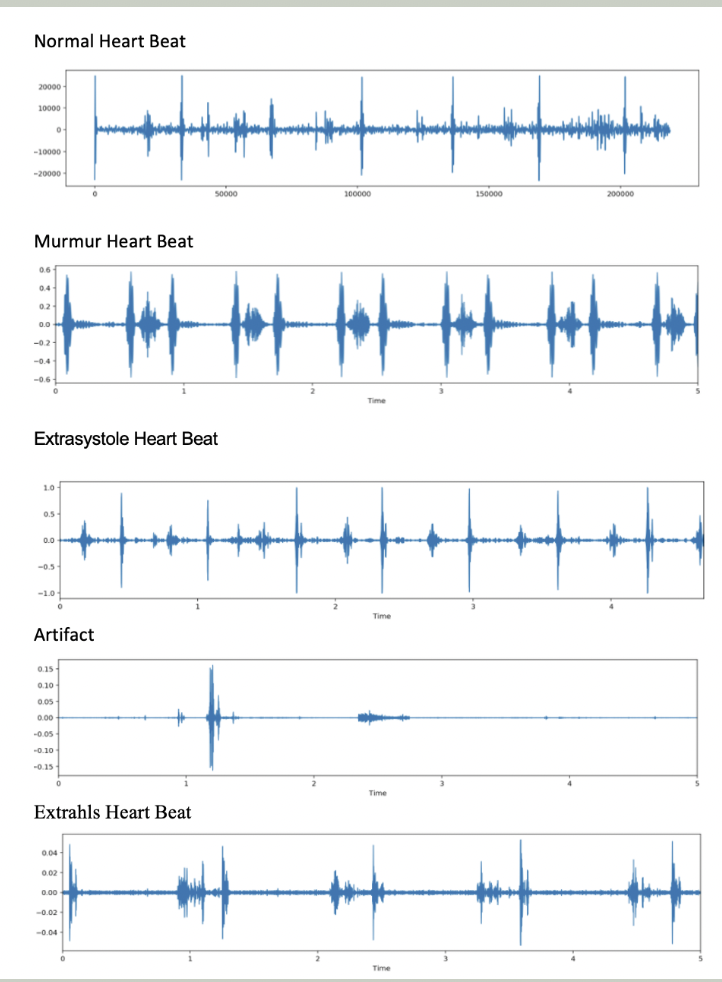

In [ ]:
print(Dataset["label"].value_counts())

normal        351
murmur        129
extrastole     46
artifact       40
extrahls       19
Name: label, dtype: int64


In [ ]:
def noise_function(data):
    noise_value = 0.009 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    
    return data

def stretch_function(data,rate=0.6):
    
    return librosa.effects.time_stretch(data,rate)

def shift_function(data):
    
    shift_range = int(np.random.uniform(-3,3) * 1000)
    return np.roll(data,shift_range)

def pitch_function(data,sampling_rate,pitch_factor=0.3):
    
    return librosa.effects.pitch_shift(data,sampling_rate,pitch_factor)

def extract_function(data):
    
    output_result = np.array([])
    
    mean_zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
    output_result = np.hstack((output_result,mean_zero_crossing_rate))
    
    stft_output = np.abs(librosa.stft(data))
    chroma_mean = np.mean(librosa.feature.chroma_stft(S=stft_output,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,chroma_mean))
    
    mfcc_output = np.mean(librosa.feature.mfcc(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mfcc_output))
    
    root_output = np.mean(librosa.feature.rms(y=data).T,axis=0)
    output_result = np.hstack((output_result,root_output))
    
    mel_output = np.mean(librosa.feature.melspectrogram(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mel_output))
    
    return output_result

def export_function(path):
    
    data,sample_rate = librosa.load(path,duration=6.0)
    
    Output_One = extract_function(data)
    result = np.array(Output_One)
    
    noise_output = noise_function(data)
    Output_Two = extract_function(noise_output)
    result = np.vstack((result,Output_Two))
    
    stretch_output = stretch_function(data)
    stretch_pitch = pitch_function(stretch_output,sample_rate)
    Output_Three = extract_function(stretch_pitch)
    result = np.vstack((result,Output_Three))
    
    return result



In [ ]:
Dataset.shape

(585, 4)

In [13]:
Dataset

,dataset,fname,label
0,a,set_a/artifact__201012172012.wav,artifact
1,a,set_a/artifact__201105040918.wav,artifact
2,a,set_a/artifact__201105041959.wav,artifact
3,a,set_a/artifact__201105051017.wav,artifact
4,a,set_a/artifact__201105060108.wav,artifact
...,...,...,...
651,b,set_b/normal_noisynormal_284_1311168471850_A.wav,normal
652,b,set_b/normal_noisynormal_284_1311168471850_B.wav,normal
653,b,set_b/normal_noisynormal_285_1311169246969_C.wav,normal
654,b,set_b/normal_noisynormal_296_1311682952647_C.wav,normal


In [ ]:
sample_rate = 22050

x_Train = []
y_Train = []
    
for path,category_wav in zip(ruta+"/"+Dataset.fname,Dataset.label):
    
    try:  
        wav_features = export_function(path)
    
        for indexing in wav_features:
            x_Train.append(indexing)
            y_Train.append(category_wav)

    except Exception as e:
        print("NO DIRECTORY ERROR: ", path)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [36]:
New_Heartbeat_Wav = pd.DataFrame(x_Train)
New_Heartbeat_Wav["CATEGORY"] = y_Train

New_Heartbeat_Wav.to_csv(ruta+"/"+"New_Wav_Heartbeat_Data6seconds.csv",index=False)

New_Heartbeat_Wav.head(-1)

NameError: ignored

In [14]:
New_Heartbeat_Wav = pd.read_csv(ruta + "/" + "New_Wav_Heartbeat_Data6seconds.csv")
New_Heartbeat_Wav.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,CATEGORY
0,0.314282,0.857650,0.857557,0.841285,0.840613,0.830529,0.820379,0.823698,0.828561,0.841397,0.843919,0.846339,0.851469,-582.094055,47.200562,7.688442,9.890503,4.265716,1.846868,-0.049489,-1.257309,-2.749013,-0.476970,-2.261281,-1.688432,-3.283469,-2.725904,-2.646496,-1.953506,-2.277625,-1.739497,-2.460650,-1.251426,0.003830,0.002500,0.014010,0.064270,0.508388,1.065809,0.652331,...,0.000336,0.000201,0.000329,0.000147,0.000290,0.000126,0.000242,0.000121,0.000196,0.000127,0.000141,0.000139,0.000094,0.000130,0.000089,0.000087,0.000097,0.000070,0.000063,0.000065,0.000056,0.000047,0.000043,4.123385e-05,3.776096e-05,3.281531e-05,2.972953e-05,2.747011e-05,2.524741e-05,2.313811e-05,2.135236e-05,1.947777e-05,1.719702e-05,1.494835e-05,1.303688e-05,1.089896e-05,7.449113e-06,2.196322e-06,1.446941e-07,artifact
1,0.471587,0.887244,0.906401,0.925217,0.941154,0.953123,0.875596,0.780019,0.799670,0.821794,0.830009,0.852574,0.874506,-326.690294,4.878271,4.183270,3.094567,1.556875,0.436836,-0.149433,-0.446185,-0.544418,-0.754879,-0.971746,-0.916556,-0.894619,-0.998698,-0.950851,-0.670251,-0.321741,-0.418692,-0.485332,-0.734253,0.007260,0.003750,0.015199,0.065398,0.512646,1.064131,0.650478,...,0.001680,0.001526,0.001518,0.001377,0.001475,0.001347,0.001503,0.001407,0.001427,0.001345,0.001326,0.001458,0.001350,0.001375,0.001283,0.001290,0.001299,0.001296,0.001271,0.001235,0.001286,0.001298,0.001306,1.269835e-03,1.268042e-03,1.246856e-03,1.259184e-03,1.232487e-03,1.245327e-03,1.237947e-03,1.230896e-03,1.239922e-03,1.233142e-03,1.221115e-03,1.260333e-03,1.249307e-03,1.236604e-03,1.250947e-03,1.208807e-03,artifact
2,0.209169,0.813688,0.806130,0.791093,0.778702,0.766259,0.780432,0.795921,0.784312,0.811032,0.808998,0.810089,0.799495,-623.430115,38.407024,11.653417,9.166087,4.782164,3.125971,0.073683,-1.377059,-1.751022,-0.542324,-1.642969,-1.805746,-2.919215,-2.423160,-2.026521,-1.406376,-1.066840,-0.974283,-2.308011,-1.415078,0.002120,0.000472,0.003501,0.005971,0.111151,0.451591,0.220459,...,0.000072,0.000040,0.000109,0.000073,0.000052,0.000038,0.000043,0.000041,0.000045,0.000035,0.000049,0.000024,0.000036,0.000025,0.000024,0.000024,0.000019,0.000024,0.000013,0.000014,0.000013,0.000014,0.000011,9.135175e-06,8.268111e-06,8.205790e-06,9.856739e-06,7.378403e-06,4.833499e-06,4.918133e-06,4.456452e-06,3.905578e-06,4.505549e-06,4.447368e-06,3.362620e-06,2.902974e-06,1.942576e-06,4.008682e-07,1.494699e-08,artifact
3,0.594304,0.886154,0.918500,0.949922,0.911648,0.653659,0.557030,0.587709,0.642208,0.701188,0.749561,0.788040,0.841987,-893.794617,0.950350,12.248739,-10.911751,2.570543,-1.767809,-3.126129,3.474917,-6.655434,3.891176,-5.512231,2.284050,-3.012799,1.437197,-3.060279,1.695604,-3.823021,2.667723,-3.369455,2.280892,0.000213,0.000034,0.000025,0.000032,0.000048,0.000099,0.000344,...,0.000005,0.000004,0.000005,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000002,0.000002,0.000002,0.000003,0.000003,0.000002,0.000003,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001,8.986482e-07,8.417642e-07,9.982356e-07,7.034336e-07,6.004100e-07,7.047093e-07,7.347949e-07,5.296774e-07,6.571493e-07,6.331764e-07,6.100354e-07,5.859208e-07,5.377673e-07,3.945727e-07,1.056890e-07,6.750118e-09,artifact
4,0.441861,0.898899,0.901885,0.912343,0.936061,0.921076,0.827107,0.773266,0.788028,0.811133,0.829465,0.846763,0.873222,-774.954213,16.427688,-3.475030,0.498055,-3.548470,0.174270,-1.664726,-0.182645,-2.646686,0.183678,-2.156205,0.486775,-1.572875,0.450379,-1.734350,0.249773,-2.025698,0.548909,-1.390484,0.758208,0.000222,0.000034,0.000025,0.000032,0.000048,0.000099,0.000344,...,0.000005,0.000004,0.000005,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000002,0.000002,0.000002,0.000

In [15]:
Encoder_Function = OneHotEncoder()
Scaler_Function = MinMaxScaler()
Values_X = New_Heartbeat_Wav.iloc[:,:-1].values
Labels_X = New_Heartbeat_Wav["CATEGORY"].values

In [16]:
print(Values_X.shape)
print(Labels_X.shape)

(1755, 162)
(1755,)


In [17]:
Labels_X_Encode = Encoder_Function.fit_transform(np.array(Labels_X).reshape(-1,1)).toarray()

In [18]:
print(Labels_X_Encode.shape)

(1755, 5)


In [19]:
xTrain,xTest,yTrain,yTest = train_test_split(Values_X,Labels_X_Encode,train_size=0.8,random_state=42,shuffle=True)

In [20]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(1404, 162)
(1404, 5)
(351, 162)
(351, 5)


In [21]:
xTrain = np.expand_dims(xTrain,axis=2)
xTest = np.expand_dims(xTest,axis=2)

In [22]:
print(xTrain.shape)
print(xTest.shape)

(1404, 162, 1)
(351, 162, 1)


In [23]:
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
output_dim = 5
compile_metrics = ["accuracy"]
compile_loss = "categorical_crossentropy"
compile_optimizer = Adam()
input_shape_dim = (xTrain.shape[1],1)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(Values_X,Labels_X_Encode, train_size=0.8, random_state = 42, shuffle=True)

In [25]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1404, 162)
(1404, 5)
(351, 162)
(351, 5)


# Convulational Network Approach

Se creo el siguiente modelo para poder llegar al accuracy deseado.

In [31]:
X_train = X_train.reshape(X_train.shape[0], 18, 9, 1)
X_test = X_test.reshape(X_test.shape[0], 18, 9, 1)

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1404, 18, 9, 1)
(1404, 5)
(351, 18, 9, 1)
(351, 5)


In [40]:
import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, SimpleRNN
import tensorflow as tf
                        
from keras.layers import LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape,\
Conv2DTranspose, LeakyReLU, Conv1D, AveragePooling1D, MaxPooling1D, MaxPool1D, GlobalAvgPool1D

In [37]:
act = keras.layers.LeakyReLU(alpha=0.3)
Model_Conv2D = Sequential()


Model_Conv2D.add(Conv2D(16,(3, 3),padding="same",activation=act,input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
#Model_Conv2D.add(Conv2D(64,(3, 3),padding="same",activation="relu",input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))

Model_Conv2D.add(MaxPool2D(pool_size=(2, 2)))

Model_Conv2D.add(Conv2D(32, (3, 3), padding = "same", activation = act))
Model_Conv2D.add(MaxPool2D(pool_size=(2, 2)))

Model_Conv2D.add(Conv2D(64, (3, 3), padding = "same", activation = "relu"))
Model_Conv2D.add(MaxPool2D(pool_size=(2, 2)))

#
Model_Conv2D.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
Model_Conv2D.add(Dropout(0.3))
Model_Conv2D.add(MaxPool2D(pool_size=(1, 1)))

Model_Conv2D.add(Conv2D(256, (3, 3), padding = "same", activation = "relu"))
Model_Conv2D.add(Dropout(0.3))
Model_Conv2D.add(MaxPool2D(pool_size=(1, 1)))


Model_Conv2D.add(Conv2D(512, (3, 3), padding = "same", activation = "relu"))
Model_Conv2D.add(Dropout(0.3))
Model_Conv2D.add(MaxPool2D(pool_size=(1, 1)))

Model_Conv2D.add(Conv2D(1024, (3, 3), padding = "same", activation = "relu"))
Model_Conv2D.add(Dropout(0.3))
Model_Conv2D.add(MaxPool2D(pool_size=(1, 1)))


#
Model_Conv2D.add(Flatten())
Model_Conv2D.add(Dense(2048, activation = "relu"))
Model_Conv2D.add(Dropout(0.5))

Model_Conv2D.add(Dense(output_dim, activation = "softmax"))

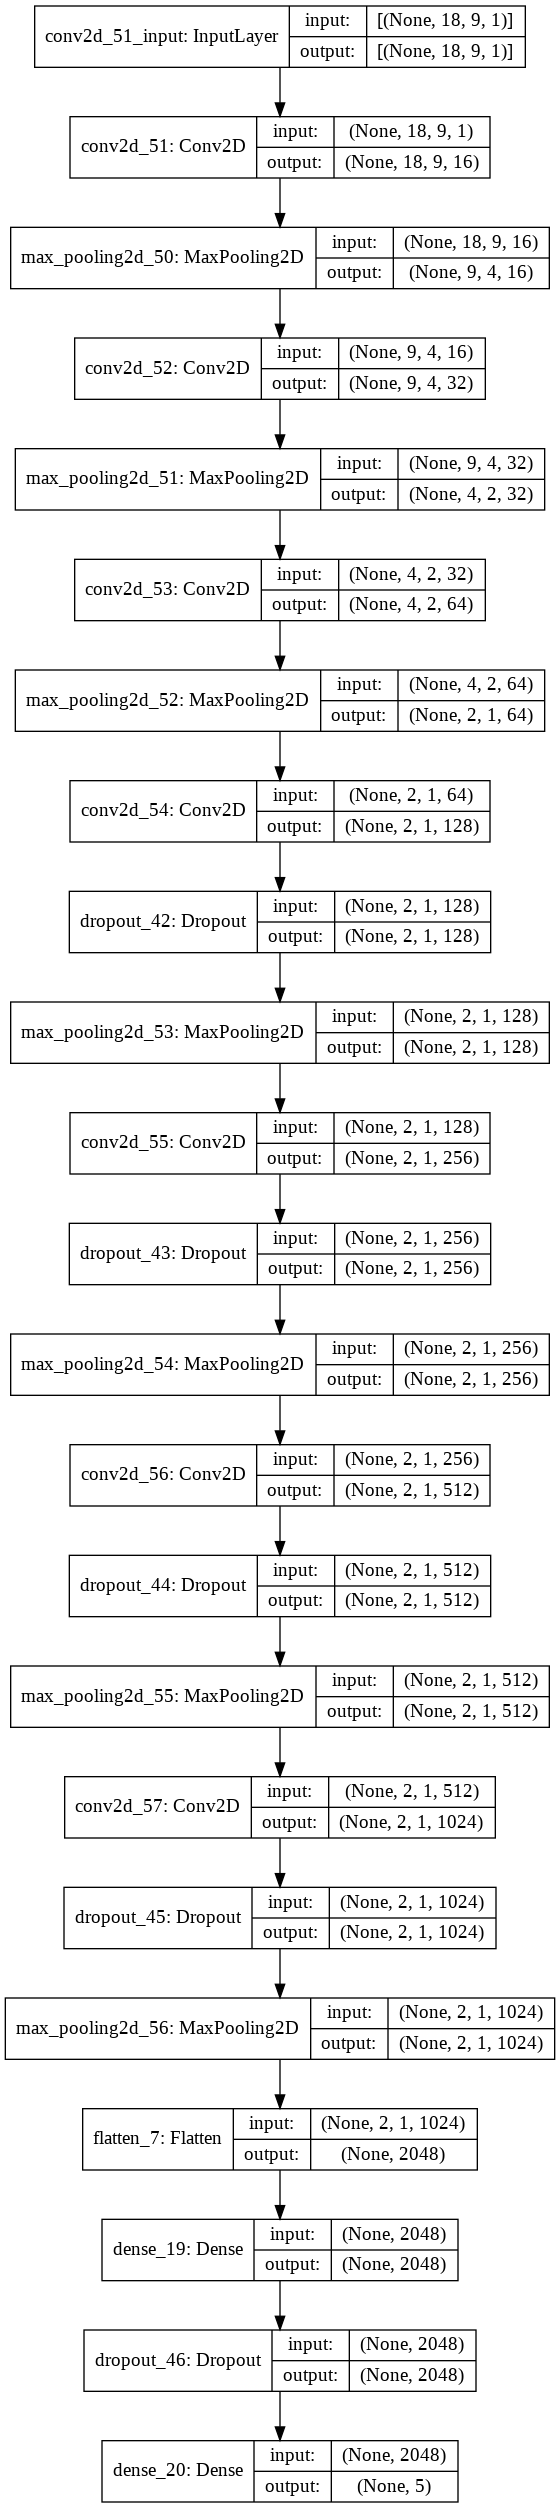

In [94]:
img_file = './model_arch.png'
tf.keras.utils.plot_model(Model_Conv2D, to_file=img_file, show_shapes=True, show_layer_names=True)

In [41]:
Model_Check_Conv2D = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                     save_best_only=True,
                                                     filepath="./my_Conv2D_model")

In [43]:
Model_Conv2D.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 9, 16)         160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 4, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 4, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 1, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 1, 128)        

In [96]:
Model_Conv2D.compile(optimizer=compile_optimizer,loss=compile_loss,metrics=compile_metrics)
Conv2D_Model = Model_Conv2D.fit(X_train, Y_train, batch_size=64, epochs=70,
                                validation_data=(X_test, Y_test), callbacks=[Early_Stopper,Model_Check_Conv2D])

Epoch 1/70
22/22 [==============================] - 70s 2s/step - loss: 1.5811 - accuracy: 0.5185 - val_loss: 1.1656 - val_accuracy: 0.5783
Epoch 2/70
22/22 [==============================] - 39s 2s/step - loss: 1.0949 - accuracy: 0.6097 - val_loss: 1.0706 - val_accuracy: 0.5926
Epoch 3/70
22/22 [==============================] - 39s 2s/step - loss: 0.9980 - accuracy: 0.6232 - val_loss: 0.9758 - val_accuracy: 0.6154
Epoch 4/70
22/22 [==============================] - 39s 2s/step - loss: 0.9024 - accuracy: 0.6382 - val_loss: 0.8650 - val_accuracy: 0.6239
Epoch 5/70
22/22 [==============================] - 39s 2s/step - loss: 0.9216 - accuracy: 0.6368 - val_loss: 0.9342 - val_accuracy: 0.6211
Epoch 6/70
22/22 [==============================] - 38s 2s/step - loss: 0.8839 - accuracy: 0.6610 - val_loss: 0.9254 - val_accuracy: 0.6296
Epoch 7/70
22/22 [==============================] - 39s 2s/step - loss: 0.8570 - accuracy: 0.6560 - val_loss: 0.8607 - val_accuracy: 0.6638
Epoch 8/70
22/22 [==

<Figure size 1584x720 with 0 Axes>

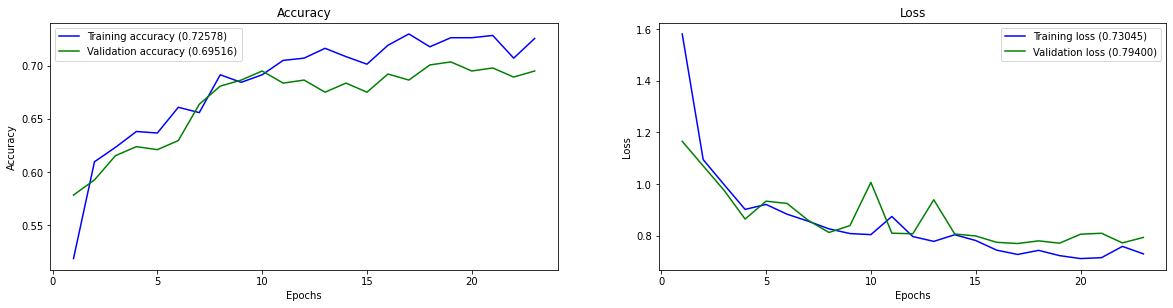

In [99]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(Conv2D_Model)

# Recurrent Neural network (RNN)

Se creo un modelo con un red neuronal Recurrente utilizando LSTM y nodos bidireccionales.

In [45]:
New_Heartbeat_Wav = pd.read_csv(ruta+"/New_Wav_Heartbeat_Data6seconds.csv")
New_Heartbeat_Wav.head()
Encoder_Function = OneHotEncoder()
Scaler_Function = MinMaxScaler()
Values_X = New_Heartbeat_Wav.iloc[:,:-1].values
Labels_X = New_Heartbeat_Wav["CATEGORY"].values
Labels_X_Encode = Encoder_Function.fit_transform(np.array(Labels_X).reshape(-1,1)).toarray()
xTrain,xTest,yTrain,yTest = train_test_split(Values_X,Labels_X_Encode,train_size=0.8,random_state=42,shuffle=True)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(1404, 162)
(1404, 5)
(351, 162)
(351, 5)


In [63]:
import tensorflow as tf
X_train, X_test, Y_train, Y_test = train_test_split(Values_X,Labels_X_Encode, train_size=0.9, random_state = 42, shuffle=True)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
print(X_train.shape)
print(X_test.shape)

(1579, 162, 1)
(176, 162, 1)


In [46]:
Model_Check_LSTM = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                     save_best_only=True,
                                                     filepath="./my_LSTM_model")

In [56]:
Model_Check_LSTM = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                     save_best_only=True,
                                                     filepath="./my_LSTM_model")
Model_LSTM = Sequential()

Model_LSTM.add(Bidirectional(LSTM(units=128,
                                  dropout=0.2,
                                  return_sequences=True),
                             input_shape=(X_train.shape[1],X_train.shape[2])))

Model_LSTM.add(Bidirectional(LSTM(units=64,
                                  dropout=0.2,
                                  return_sequences=True)))

Model_LSTM.add(Bidirectional(LSTM(units=32,
                                  dropout=0.2,
                                  return_sequences=True)))

Model_LSTM.add(Bidirectional(LSTM(units=16,
                                  dropout=0.2,
                                  return_sequences=False)))

Model_LSTM.add(Dense(5, activation='softmax'))
Model_LSTM.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 162, 256)          133120    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 162, 128)          164352    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 162, 64)           41216     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 32)                10368     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
Total params: 349,221
Trainable params: 349,221
Non-trainable params: 0
_________________________________________________________________


In [58]:
X_train = X_train.reshape(xTrain.shape[0], xTrain.shape[1],1)
X_test = X_test.reshape(xTest.shape[0], xTest.shape[1],1)
print(X_train.shape)
print(X_test.shape)

(1404, 162, 1)
(351, 162, 1)


In [60]:
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
output_dim = 5
compile_metrics = ["accuracy"]
compile_loss = "categorical_crossentropy"
compile_optimizer = Adam()
Model_LSTM.compile(optimizer="rmsprop",loss=compile_loss,metrics=compile_metrics)

In [64]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
LSTM_Model = Model_LSTM.fit(X_train, Y_train, epochs=70,
                                validation_data=(X_test, Y_test), callbacks=[Early_Stopper,Model_Check_LSTM])

Epoch 1/70
50/50 [==============================] - 39s 778ms/step - loss: 0.8596 - accuracy: 0.6650 - val_loss: 0.8973 - val_accuracy: 0.6080
Epoch 2/70
50/50 [==============================] - 39s 784ms/step - loss: 0.8374 - accuracy: 0.6688 - val_loss: 0.9253 - val_accuracy: 0.6136
Epoch 3/70
50/50 [==============================] - 39s 781ms/step - loss: 0.8453 - accuracy: 0.6605 - val_loss: 0.9024 - val_accuracy: 0.6136
Epoch 4/70
50/50 [==============================] - 39s 787ms/step - loss: 0.8354 - accuracy: 0.6675 - val_loss: 0.8932 - val_accuracy: 0.6136
Epoch 5/70
50/50 [==============================] - 39s 781ms/step - loss: 0.8597 - accuracy: 0.6574 - val_loss: 0.9209 - val_accuracy: 0.6136
Epoch 6/70
50/50 [==============================] - 39s 781ms/step - loss: 0.8300 - accuracy: 0.6643 - val_loss: 0.8754 - val_accuracy: 0.6136
Epoch 7/70
50/50 [==============================] - 39s 777ms/step - loss: 0.8300 - accuracy: 0.6599 - val_loss: 1.0468 - val_accuracy: 0.5795

INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


Epoch 9/70
50/50 [==============================] - 39s 790ms/step - loss: 0.7994 - accuracy: 0.6897 - val_loss: 0.8852 - val_accuracy: 0.6136
Epoch 10/70
50/50 [==============================] - 39s 779ms/step - loss: 0.7817 - accuracy: 0.7017 - val_loss: 0.8067 - val_accuracy: 0.6932


INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


Epoch 11/70
50/50 [==============================] - 39s 787ms/step - loss: 0.7885 - accuracy: 0.7061 - val_loss: 0.7872 - val_accuracy: 0.7102


INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


Epoch 12/70
50/50 [==============================] - 39s 782ms/step - loss: 0.7646 - accuracy: 0.7258 - val_loss: 0.8287 - val_accuracy: 0.6818
Epoch 13/70
50/50 [==============================] - 39s 779ms/step - loss: 0.7564 - accuracy: 0.7207 - val_loss: 1.0347 - val_accuracy: 0.5341
Epoch 14/70
50/50 [==============================] - 39s 785ms/step - loss: 0.7620 - accuracy: 0.7137 - val_loss: 0.7895 - val_accuracy: 0.6989
Epoch 15/70
50/50 [==============================] - 39s 783ms/step - loss: 0.7569 - accuracy: 0.7194 - val_loss: 0.7921 - val_accuracy: 0.7045
Epoch 16/70
50/50 [==============================] - 39s 780ms/step - loss: 0.7561 - accuracy: 0.7163 - val_loss: 0.7913 - val_accuracy: 0.6875
Epoch 17/70
50/50 [==============================] - 39s 788ms/step - loss: 0.7632 - accuracy: 0.7125 - val_loss: 0.8243 - val_accuracy: 0.6534
Epoch 18/70
50/50 [==============================] - 39s 787ms/step - loss: 0.7532 - accuracy: 0.7201 - val_loss: 0.7608 - val_accuracy:

INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


Epoch 19/70
50/50 [==============================] - 39s 787ms/step - loss: 0.7373 - accuracy: 0.7239 - val_loss: 0.7861 - val_accuracy: 0.6761
Epoch 20/70
50/50 [==============================] - 39s 780ms/step - loss: 0.7370 - accuracy: 0.7251 - val_loss: 0.8064 - val_accuracy: 0.6761
Epoch 21/70
50/50 [==============================] - 39s 780ms/step - loss: 0.7430 - accuracy: 0.7220 - val_loss: 0.7981 - val_accuracy: 0.6818
Epoch 22/70
50/50 [==============================] - 39s 782ms/step - loss: 0.7425 - accuracy: 0.7315 - val_loss: 0.7617 - val_accuracy: 0.7102
Epoch 23/70
50/50 [==============================] - 39s 783ms/step - loss: 0.7239 - accuracy: 0.7270 - val_loss: 0.7334 - val_accuracy: 0.7045
Epoch 24/70
50/50 [==============================] - 39s 777ms/step - loss: 0.7310 - accuracy: 0.7277 - val_loss: 0.7583 - val_accuracy: 0.7102
Epoch 25/70
50/50 [==============================] - 39s 784ms/step - loss: 0.7455 - accuracy: 0.7213 - val_loss: 0.7829 - val_accuracy:

INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


INFO:tensorflow:Assets written to: ./my_LSTM_model/assets


<Figure size 1584x720 with 0 Axes>

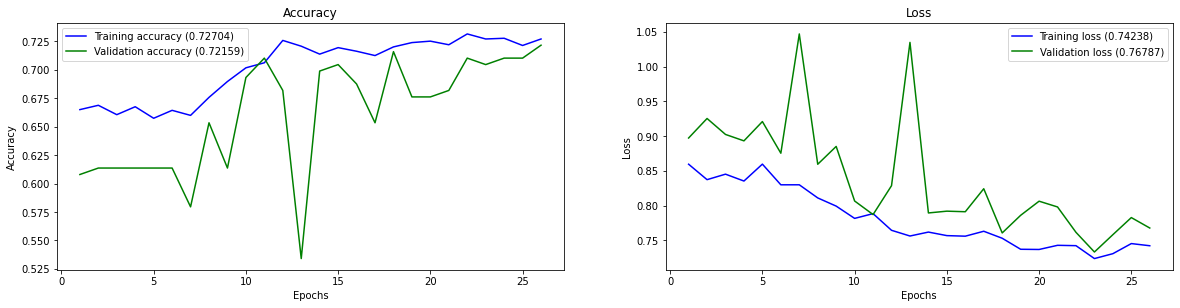

In [65]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(LSTM_Model)

# Conclusiones

El trabajo con el feature extraction de sonidos es bastante compleja y creo que aun debo de explorar mas posibilidades para efectuar el feature extraction. 

Es posible que sea necesario eliminar una de las categorias denominada artifact, pues no corresponde a ningun latido del corazon. 

Sin duda alguna la recoleccion y transformacion de datos es necesaria para poder utilizar de manera adecuada las redes neuronales.

